In [1]:
import os
import glob
import zipfile
import functools

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image

In [19]:
import tensorflow as tf
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Downloading dataset if not exists

In [3]:
def get_kaggle_credentials():
  token_dir = os.path.join(os.path.expanduser("~"),".kaggle")
  token_file = os.path.join(token_dir, "kaggle.json")
  if not os.path.isdir(token_dir):
    os.mkdir(token_dir)
  try:
    with open(token_file,'r') as f:
      pass
  except IOError as no_file:
    try:
      from google.colab import files
    except ImportError:
      raise no_file
    
    uploaded = files.upload()
    
    if "kaggle.json" not in uploaded:
      raise ValueError("You need an API key! see: "
                       "https://github.com/Kaggle/kaggle-api#api-credentials")
    with open(token_file, "wb") as f:
      f.write(uploaded["kaggle.json"])
    os.chmod(token_file, 600)

def Unzip(filename, path):
  with zipfile.ZipFile(filename, 'r') as zf:
      zf.extractall(path)

def download():
  if not os.path.isdir('./COVID-19 Radiography Database'):
    !pip install kaggle
    get_kaggle_credentials()
    !kaggle datasets download -d tawsifurrahman/covid19-radiography-database
    Unzip("covid19-radiography-database.zip", "COVID-19 Radiography Database/")
download()

Saving kaggle.json to kaggle.json
 98% 1.13G/1.15G [00:30<00:00, 35.9MB/s]
100% 1.15G/1.15G [00:30<00:00, 40.4MB/s]


# Setting Up Train Data by copying all images of classes Normal vs Covid in one Folder.

In [26]:
!cp -R "/content/COVID-19 Radiography Database/COVID-19 Radiography Database/NORMAL" "/content/Train_data"
!cp -R "/content/COVID-19 Radiography Database/COVID-19 Radiography Database/COVID-19" "/content/Train_data"
train_data_dir= "/content/Train_data"

# Note: This model is just a slight deviation from Kaggle notebook and is just a PoC

In [16]:
def get_Sequential_model1():
  model=tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(8, (3,3), activation='relu', input_shape=(64, 64, 3)))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"))
  model.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(32))
  model.add(tf.keras.layers.Dropout(.1, input_shape=(32,)))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  return model

In [27]:
img_height, img_width=64,64
batch_size=16
train_datagen = ImageDataGenerator(validation_split=0.3) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training') # set as training data
# Splitting images for validation set
validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation')

Found 1093 images belonging to 2 classes.
Found 467 images belonging to 2 classes.


In [28]:
model = get_Sequential_model1()
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics = ['accuracy'])

trainer=model.fit(train_generator,validation_data=validation_generator,epochs=10,verbose=2)

Epoch 1/10
69/69 - 23s - loss: 4.7774 - accuracy: 0.8801 - val_loss: 8.5892 - val_accuracy: 0.8822
Epoch 2/10
69/69 - 23s - loss: 3.1370 - accuracy: 0.9177 - val_loss: 1.7236 - val_accuracy: 0.9507
Epoch 3/10
69/69 - 23s - loss: 0.9557 - accuracy: 0.9671 - val_loss: 1.0035 - val_accuracy: 0.9657
Epoch 4/10
69/69 - 23s - loss: 0.5919 - accuracy: 0.9726 - val_loss: 0.7588 - val_accuracy: 0.9679
Epoch 5/10
69/69 - 23s - loss: 0.6391 - accuracy: 0.9661 - val_loss: 0.7188 - val_accuracy: 0.9743
Epoch 6/10
69/69 - 23s - loss: 0.3981 - accuracy: 0.9780 - val_loss: 0.6954 - val_accuracy: 0.9636
Epoch 7/10
69/69 - 22s - loss: 0.3814 - accuracy: 0.9744 - val_loss: 1.2553 - val_accuracy: 0.9550
Epoch 8/10
69/69 - 23s - loss: 0.6196 - accuracy: 0.9597 - val_loss: 1.1489 - val_accuracy: 0.9679
Epoch 9/10
69/69 - 23s - loss: 0.3863 - accuracy: 0.9762 - val_loss: 0.5468 - val_accuracy: 0.9743
Epoch 10/10
69/69 - 23s - loss: 0.2833 - accuracy: 0.9854 - val_loss: 0.7176 - val_accuracy: 0.9743


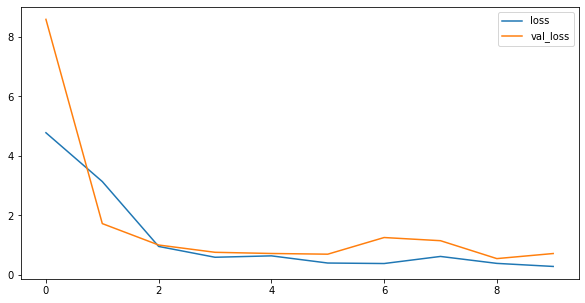

In [29]:
plt.figure(figsize=(10,5))
plt.plot(trainer.history["loss"],label="loss")
plt.plot(trainer.history["val_loss"],label="val_loss")
plt.legend()